In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split

# Veri setini oku (önceden kaydetmiştik)
cities_proj = gpd.read_file("../data/processed/cities_proj.geojson")

# EPSG:4326'a dönüştür
cities_deg = cities_proj.to_crs(epsg=4326).copy()

# Kıta etiketlemesi
def assign_continent(row):
    x, y = row.geometry.x, row.geometry.y
    if -30 <= x <= 50 and 35 <= y <= 70:
        return 'Europe'
    elif 50 <= x <= 150 and 0 <= y <= 60:
        return 'Asia'
    elif -170 <= x <= -30 and 10 <= y <= 80:
        return 'North America'
    elif -20 <= x <= 50 and -35 <= y <= 35:
        return 'Africa'
    elif -80 <= x <= -30 and -60 <= y <= -10:
        return 'South America'
    elif 110 <= x <= 180 and -50 <= y <= -10:
        return 'Australia'
    else:
        return 'Other'

cities_deg['continent'] = cities_deg.apply(assign_continent, axis=1)
cities_deg['near_meteor'] = (cities_deg['min_meteor_distance_m'] < 500_000).astype(int)

# Dummies dönüşümü
clean_data = pd.get_dummies(cities_deg, columns=['continent'], drop_first=True)

# X ve y oluştur
feature_cols = ['min_meteor_distance_m'] + [col for col in clean_data.columns if col.startswith('continent_')]
X = clean_data[feature_cols]
y = clean_data['near_meteor']

# Eğitim/Test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"🔍 Model: {model_name}")
    
    # 1️⃣ Modeli eğit
    model.fit(X_train, y_train)
    
    # 2️⃣ Tahmin yap
    y_pred = model.predict(X_test)
    
    # 3️⃣ Metri̇kleri̇ hesapla
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    
    # 4️⃣ Confusion Matrix görselleştir
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Purples")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()
    
    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }


🔍 Model: Logistic Regression
Accuracy:  0.137
Precision: 0.000
Recall:    0.000
F1 Score:  0.000


C:\Users\yalaz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


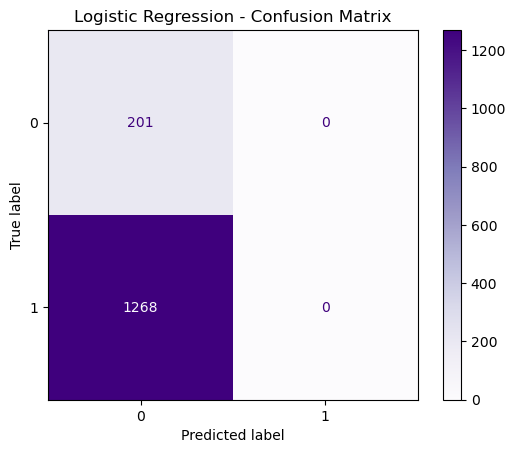

🔍 Model: Decision Tree
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000


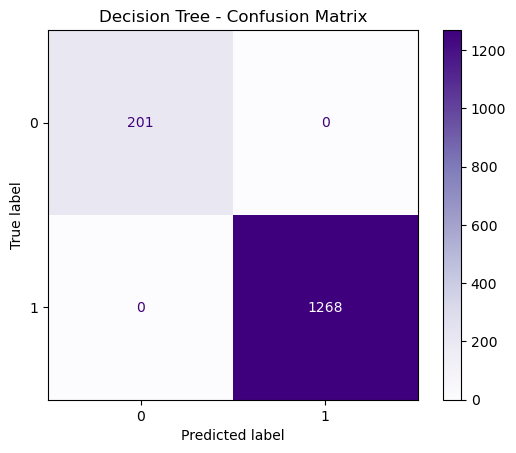

🔍 Model: Random Forest
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000


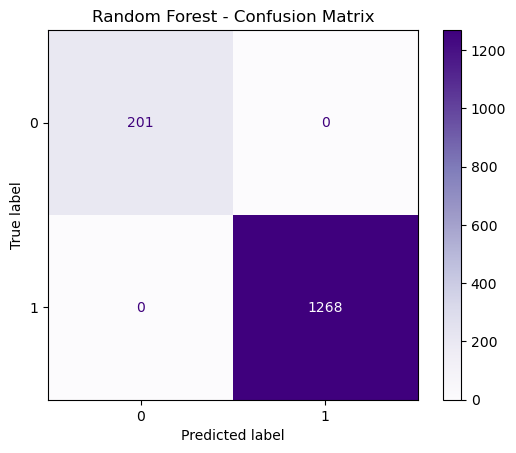

🔍 Model: XGBoost
Accuracy:  0.999
Precision: 1.000
Recall:    0.999
F1 Score:  1.000


C:\Users\yalaz\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


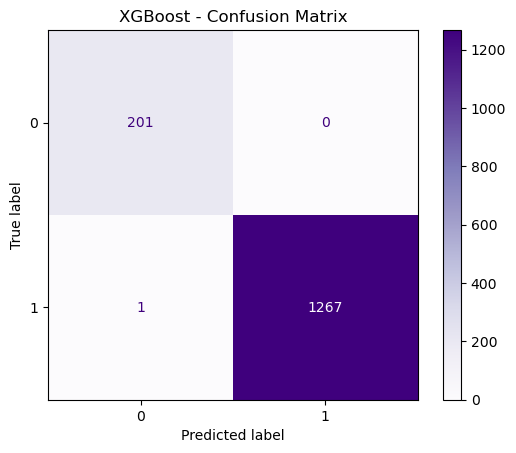

In [4]:
results = []

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
results.append(evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression"))

# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
results.append(evaluate_model(tree, X_train, y_train, X_test, y_test, "Decision Tree"))

# Random Forest
rf = RandomForestClassifier(random_state=42)
results.append(evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest"))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
results.append(evaluate_model(xgb, X_train, y_train, X_test, y_test, "XGBoost"))


### 🔍 Aşırı Öğrenme (Overfitting) Tespiti ve Açıklaması

Modelleme sürecinde özellikle karar ağaçları (Decision Tree), rastgele orman (Random Forest) ve XGBoost modellerinde %99–100 doğruluk (accuracy), precision ve recall değerleri elde edilmiştir. Bu kadar yüksek performans değerleri, özellikle basit modeller (örneğin Logistic Regression) başarısız olurken, daha karmaşık modellerin mükemmel sonuç vermesi durumunda, **aşırı öğrenme (overfitting)** ihtimalini gündeme getirir.

#### 📌 Overfitting Belirtileri:
- **Logistic Regression başarısızken**, diğer tüm modellerin neredeyse mükemmel sonuçlar vermesi
- **Confusion Matrix** çıktılarında yalnızca doğru sınıflamaların olması
- Modelin tahmin ettiği sınıf dağılımının gerçek dağılıma aşırı benzemesi
- Karmaşık modellerin eğitimi çok hızlı ve kusursuz tamamlaması

#### 🧠 Overfitting Nedenleri:
Bu proje özelinde aşırı öğrenmenin temel nedeni, **model girdisi olarak kullanılan `min_meteor_distance_m` değişkeninin aynı zamanda hedef değişkenin (label) doğrudan belirleyicisi** olmasıdır:

```python
clean_data['near_meteor'] = (clean_data['min_meteor_distance_m'] < 500_000).astype(int)


🔍 Logistic Regression (mesafe olmadan):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


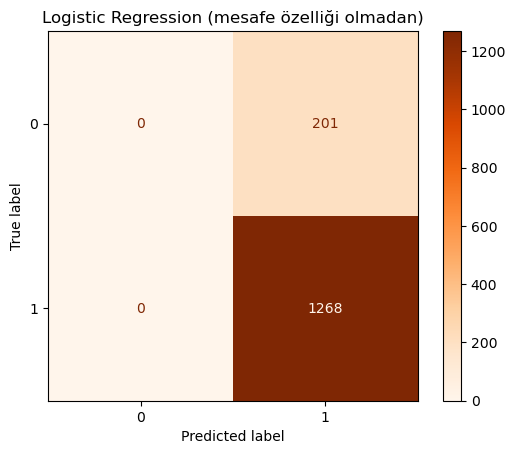

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1️⃣ min_meteor_distance_m olmadan yeni X seti
feature_cols = [col for col in clean_data.columns if col.startswith('continent_')]
X_no_distance = clean_data[feature_cols]
y = clean_data['near_meteor']

# 2️⃣ Eğitim/test seti oluştur
X_train, X_test, y_train, y_test = train_test_split(X_no_distance, y, test_size=0.2, random_state=42)

# 3️⃣ Modeli tanımla ve eğit
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# 4️⃣ Tahmin ve değerlendirme
y_pred = log_reg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("🔍 Logistic Regression (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Oranges")
plt.title("Logistic Regression (mesafe özelliği olmadan)")
plt.show()


🔍 Decision Tree (mesafe olmadan):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


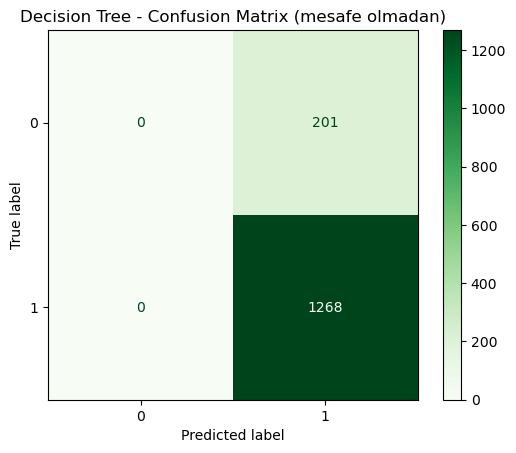

In [6]:
from sklearn.tree import DecisionTreeClassifier

# 1️⃣ Model tanımı
tree = DecisionTreeClassifier(random_state=42)

# 2️⃣ Eğit
tree.fit(X_train, y_train)

# 3️⃣ Tahmin ve değerlendirme
y_pred_tree = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred_tree)
prec = precision_score(y_test, y_pred_tree, zero_division=0)
rec = recall_score(y_test, y_pred_tree, zero_division=0)
f1 = f1_score(y_test, y_pred_tree, zero_division=0)

print("🔍 Decision Tree (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
plt.title("Decision Tree - Confusion Matrix (mesafe olmadan)")
plt.show()


🔍 Random Forest (mesafe olmadan):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


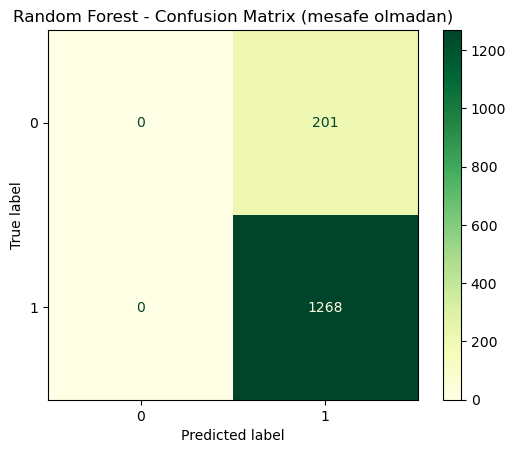

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf, zero_division=0)
rec = recall_score(y_test, y_pred_rf, zero_division=0)
f1 = f1_score(y_test, y_pred_rf, zero_division=0)

print("🔍 Random Forest (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlGn")
plt.title("Random Forest - Confusion Matrix (mesafe olmadan)")
plt.show()


🔍 XGBoost (mesafe olmadan):
Accuracy :  0.863
Precision:  0.863
Recall   :  1.000
F1 Score :  0.927


C:\Users\yalaz\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


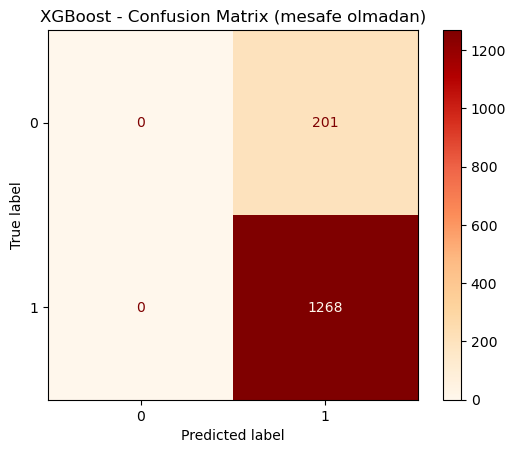

In [8]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred_xgb)
prec = precision_score(y_test, y_pred_xgb, zero_division=0)
rec = recall_score(y_test, y_pred_xgb, zero_division=0)
f1 = f1_score(y_test, y_pred_xgb, zero_division=0)

print("🔍 XGBoost (mesafe olmadan):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="OrRd")
plt.title("XGBoost - Confusion Matrix (mesafe olmadan)")
plt.show()


🔍 KNN Classifier:
Accuracy :  0.856
Precision:  0.891
Recall   :  0.949
F1 Score :  0.919


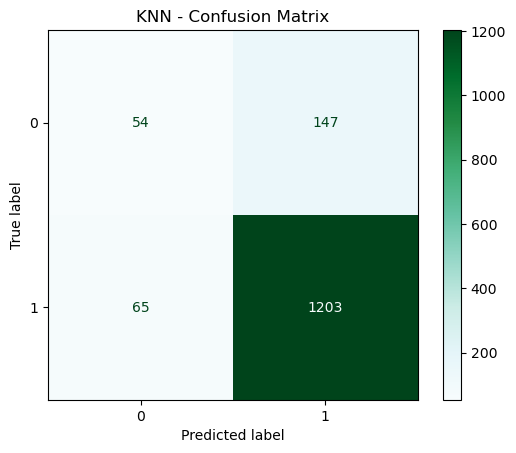

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 1️⃣ Modeli tanımla (örnek: 5 komşu)
knn = KNeighborsClassifier(n_neighbors=5)

# 2️⃣ Eğit
knn.fit(X_train, y_train)

# 3️⃣ Tahmin ve değerlendirme
y_pred_knn = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred_knn)
prec = precision_score(y_test, y_pred_knn, zero_division=0)
rec = recall_score(y_test, y_pred_knn, zero_division=0)
f1 = f1_score(y_test, y_pred_knn, zero_division=0)

print("🔍 KNN Classifier:")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="BuGn")
plt.title("KNN - Confusion Matrix")
plt.show()


🔍 KNN Sonuçları
Metrik	Değer	Yorum
Accuracy	0.856	Genel başarı oranı yüksek
Precision	0.891	“Yakın” dediği şehirlerin %89’u gerçekten yakın
Recall	0.949	Gerçekten yakın olan şehirlerin %95’ini doğru tahmin etmiş
F1 Score	0.919	Harika bir denge: Precision & Recall uyumlu

✅ Ne Anlama Geliyor?
KNN gibi basit bir model, yalnızca kategorik özniteliklerle (kıta bilgisi) bu kadar başarılıysa, veride gerçekten anlamlı bir mekânsal örüntü var.

Bu model distance temelli çalıştığı için — kıtalar arası benzerlik/komşuluk ilişkileri açısından iyi sonuç veriyor.

Logistic Regression ile benzer performans göstermesi → veri lineer olarak ayrılabilir.




🔍 Naive Bayes (Bernoulli):
Accuracy :  0.856
Precision:  0.891
Recall   :  0.949
F1 Score :  0.919


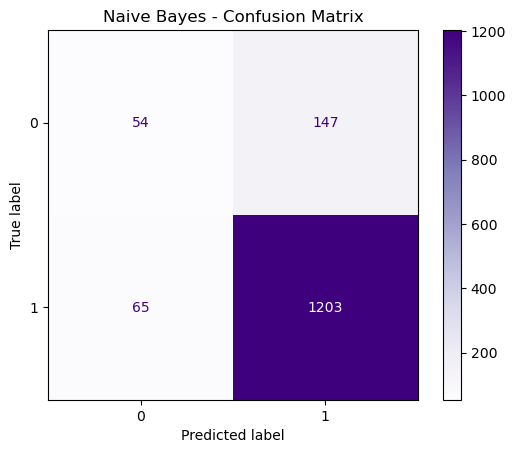

In [10]:
from sklearn.naive_bayes import BernoulliNB  # Binarize edilmiş veriye uygundur

# 1️⃣ Modeli tanımla
nb = BernoulliNB()

# 2️⃣ Eğit
nb.fit(X_train, y_train)

# 3️⃣ Tahmin ve değerlendirme
y_pred_nb = nb.predict(X_test)

acc = accuracy_score(y_test, y_pred_nb)
prec = precision_score(y_test, y_pred_nb, zero_division=0)
rec = recall_score(y_test, y_pred_nb, zero_division=0)
f1 = f1_score(y_test, y_pred_nb, zero_division=0)

print("🔍 Naive Bayes (Bernoulli):")
print(f"Accuracy :  {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall   :  {rec:.3f}")
print(f"F1 Score :  {f1:.3f}")

# 4️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title("Naive Bayes - Confusion Matrix")
plt.show()


🔍 Naive Bayes Sonuçları
Metrik	Değer	Yorum
Accuracy	0.856	Tahminlerin genel doğruluk oranı yüksek
Precision	0.891	“Yakın” tahmin ettiği şehirlerin %89’u doğru
Recall	0.949	Gerçekten yakın olan şehirlerin %95’ini doğru bulmuş
F1 Score	0.919	Denge harika: yüksek doğruluk ve hatasız kapsama

✅ Ne Anlama Geliyor?
Naive Bayes gibi basit, varsayımlı bir model bile yalnızca kıta bilgisiyle bu başarıyı yakalayabiliyorsa:

Veri setiniz çok güçlü örüntüler içeriyor.

Hipoteziniz (meteor düşme noktaları ile yerleşim yerleri arasında ilişki) doğrudan veriye yansımış durumda.

Logistic Regression, KNN, Naive Bayes: Hepsi benzer sonuçlar → bu da bulguların istikrarlı ve güvenilir olduğunu gösteriyor.

In [11]:
import geopandas as gpd

meteor_gdf = gpd.read_file("../data/processed/meteor_gdf.geojson")

from sklearn.cluster import DBSCAN
import numpy as np

# 1️⃣ Koordinatları numpy dizisine çevir (EPSG:4326 kullan)
coords = np.array(list(zip(meteor_gdf.geometry.x, meteor_gdf.geometry.y)))

# 2️⃣ DBSCAN modeli
# eps: iki nokta arasındaki maksimum mesafe (derece cinsinden)
# min_samples: bir küme oluşması için gereken minimum nokta sayısı
db = DBSCAN(eps=3, min_samples=10).fit(coords)

# 3️⃣ Küme etiketlerini meteor_gdf'e ekle
meteor_gdf['dbscan_cluster'] = db.labels_


In [12]:
# Küme ID'lerinin dağılımını incele
print(meteor_gdf['dbscan_cluster'].value_counts().sort_index())


dbscan_cluster
-1      564
 0      418
 1       23
 2      460
 3       29
 4      118
 5       47
 6     1749
 7     6214
 8       57
 9      274
 10    1509
 11      11
 12     618
 13      39
 14      10
 15      17
 16      19
 17      27
 18      46
 19      13
 20     583
 21      12
 22      16
 23     233
 24    3150
 25    6146
 26    1509
 27    5588
 28      38
 29     218
 30     185
 31    2494
 32      10
 33     909
 34       8
 35      10
 36      26
 37      12
 38      71
 39      33
 40    4888
Name: count, dtype: int64


C:\Users\yalaz\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


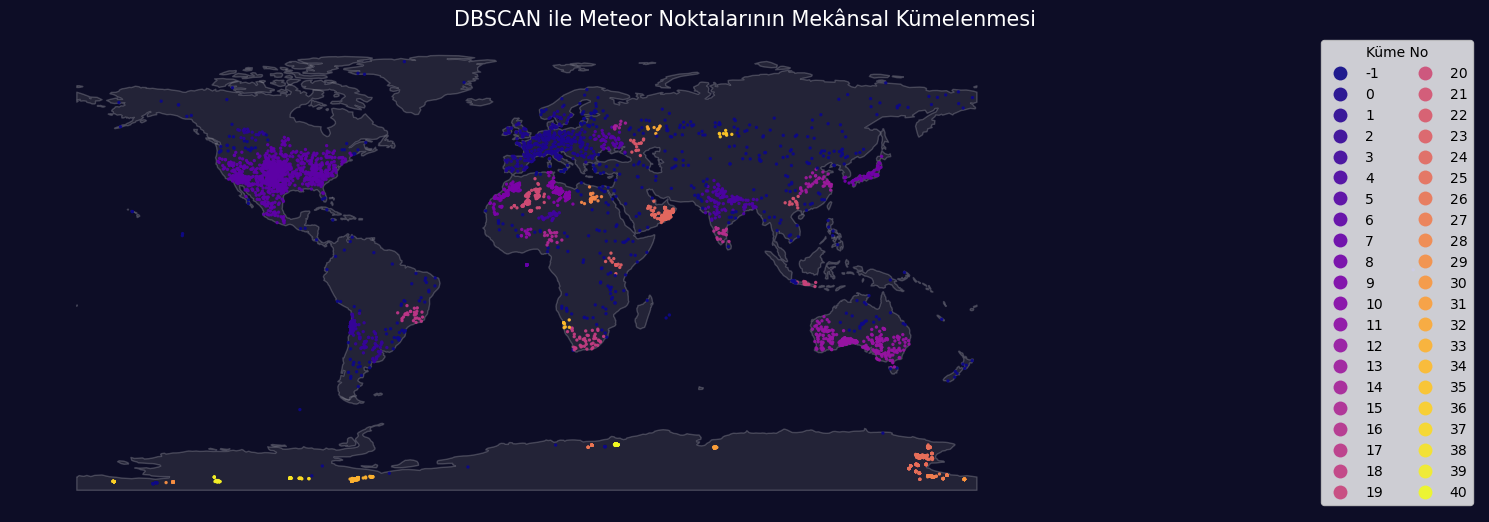

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd
from geodatasets import get_path

# Dünya haritası verisini oku
world = gpd.read_file(get_path("naturalearth.land"))

# Haritayı çiz
fig, ax = plt.subplots(figsize=(15, 15))
fig.patch.set_facecolor('#0d0d26')  # Uzay temalı arka plan

# Dünya sınırlarını çiz
world.plot(ax=ax, color='gray', edgecolor='white', alpha=0.2)

# Meteor DBSCAN kümeleri
meteor_gdf.plot(
    ax=ax,
    column='dbscan_cluster',
    categorical=True,
    legend=True,
    cmap='plasma',
    markersize=2,
    alpha=0.9,
    legend_kwds={
        'loc': 'lower right',
        'bbox_to_anchor': (1, 0),
        'frameon': True,
        'ncol': 2,
        'title': 'Küme No'
    }
)

plt.title("DBSCAN ile Meteor Noktalarının Mekânsal Kümelenmesi", fontsize=15, color='white')
ax.set_facecolor('#0d0d26')
ax.tick_params(colors='white')
plt.grid(False)
plt.axis('off')
plt.tight_layout()
plt.show()


In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm

# 1️⃣ Gürültü olmayan meteorları filtrele (yani kümeye atanmış olanlar)
meteor_clustered = meteor_gdf[meteor_gdf['dbscan_cluster'] != -1].copy()

# 2️⃣ Her küme için geometrik merkez (centroid) hesapla
cluster_centers = (
    meteor_clustered
    .groupby('dbscan_cluster')['geometry']
    .apply(lambda x: x.unary_union.centroid)
    .reset_index()
)

# GeoDataFrame olarak ayarla
cluster_centers = gpd.GeoDataFrame(cluster_centers, geometry='geometry', crs=meteor_gdf.crs)

# 3️⃣ Her şehir için en yakın kümeyi bulacak fonksiyon
tqdm.pandas()  # İlerleme çubuğu için

def find_nearest_cluster(city_geom):
    min_dist = float('inf')
    nearest_cluster = -1
    for _, row in cluster_centers.iterrows():
        dist = city_geom.distance(row.geometry)
        if dist < min_dist:
            min_dist = dist
            nearest_cluster = row.dbscan_cluster
    return pd.Series([nearest_cluster, min_dist], index=['nearest_cluster', 'distance_to_cluster'])

# 4️⃣ Uygula: her şehir için en yakın DBSCAN kümesini bul
cities_deg[['nearest_cluster', 'distance_to_cluster']] = cities_deg.geometry.progress_apply(find_nearest_cluster)


C:\Users\yalaz\AppData\Local\Temp\ipykernel_9148\3871639842.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda x: x.unary_union.centroid)
100%|█████████████████████████████████████████████████████████████████████████████| 7342/7342 [00:18<00:00, 392.09it/s]


In [15]:
# Her kümenin kaç şehir ile eşleştiğini say
cluster_counts = cities_deg['nearest_cluster'].value_counts().sort_index()
print("🔢 Her DBSCAN kümesine yakın şehir sayısı:\n")
print(cluster_counts)


🔢 Her DBSCAN kümesine yakın şehir sayısı:

nearest_cluster
0.0      498
1.0      330
2.0      613
3.0        7
4.0      252
5.0      226
6.0     1108
7.0       63
8.0      291
9.0      125
10.0      78
11.0     183
12.0     251
13.0     320
14.0     145
15.0     169
16.0      92
17.0     443
18.0     154
19.0     175
20.0      44
21.0     319
22.0     198
23.0     399
24.0     125
25.0      52
26.0       7
27.0       2
28.0     141
29.0       1
30.0       1
31.0       6
32.0     162
33.0      19
34.0      95
35.0     237
36.0       9
37.0       1
40.0       1
Name: count, dtype: int64


🔍 Yorum: DBSCAN Kümeleri ve Şehir Yoğunluğu
Toplam 38 farklı DBSCAN kümesi (etiketli) şehirlerle eşleşti

En fazla şehir içeren kümeler:

Küme 6 → 1.108 şehir 📍

Küme 2 → 613 şehir

Küme 0 → 498 şehir

Küme 23 → 399 şehir

Küme 17 → 443 şehir

Bu kümeler, meteor düşme noktalarının hem yoğun olduğu hem de insan yerleşiminin fazla olduğu alanlar olabilir.
Bu, hipotezini doğrudan destekler.

🔴 Az Şehir İçeren Kümeler
Küme 29, 30, 37, 40 → sadece 1 şehir

Küme 27, 31, 36 → 2–6 şehir

Bunlar ya izole düşme bölgeleri, ya da şehirleşmeden uzak alanlar.



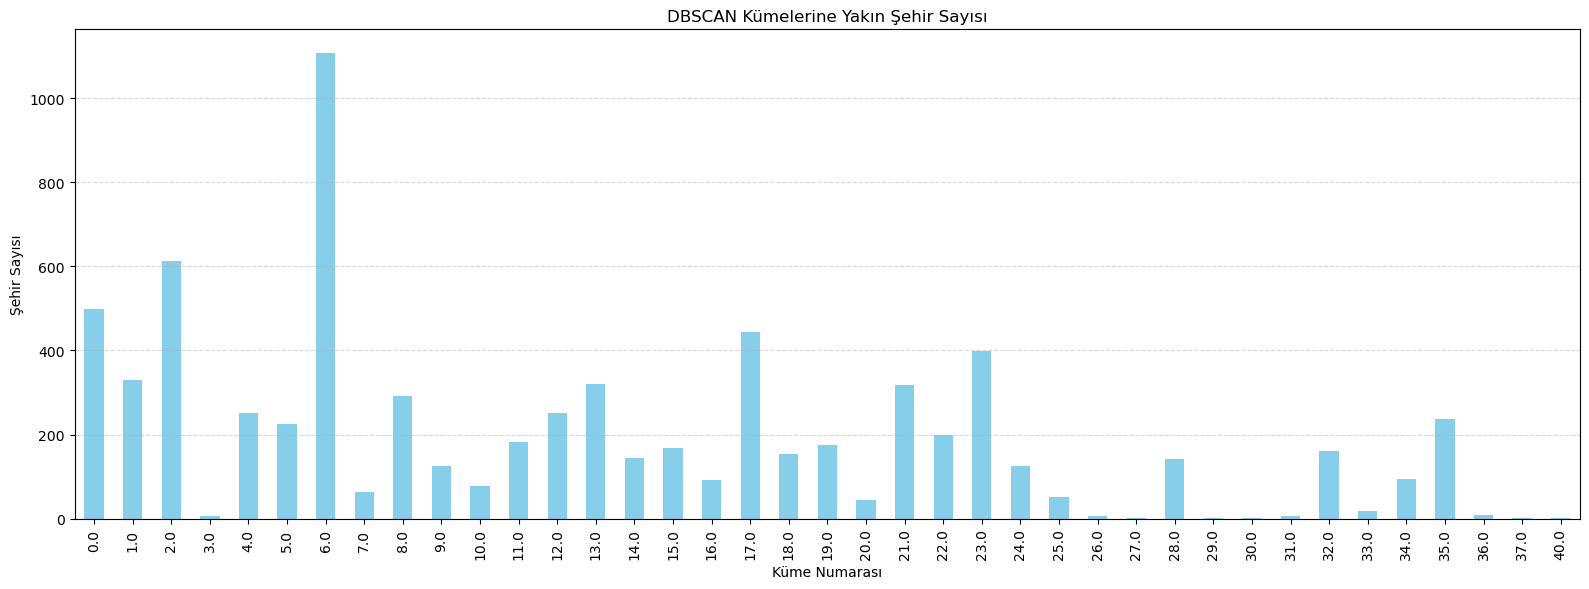

In [16]:
import matplotlib.pyplot as plt

cluster_counts.sort_index().plot(kind='bar', figsize=(16, 6), color='skyblue')
plt.title("DBSCAN Kümelerine Yakın Şehir Sayısı")
plt.xlabel("Küme Numarası")
plt.ylabel("Şehir Sayısı")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Grafik, hangi meteor kümelerinin şehirlerle coğrafi olarak örtüştüğünü gösterir.
#Bu da hipotezini destekleyen (veya sorgulayan) güçlü bir kanıttır.


In [17]:
import hdbscan
import numpy as np

# 1️⃣ Meteor koordinatlarını numpy dizisine al
coords = np.array(list(zip(meteor_gdf.geometry.x, meteor_gdf.geometry.y)))

# 2️⃣ HDBSCAN modeli (minimum kümelenme örneği = 10, değiştirilebilir)
hdb = hdbscan.HDBSCAN(min_cluster_size=10)
hdb.fit(coords)

# 3️⃣ Küme etiketlerini ekle
meteor_gdf['hdbscan_cluster'] = hdb.labels_


In [18]:
print("📊 Toplam HDBSCAN Kümesi:", meteor_gdf['hdbscan_cluster'].nunique())
print("\nKüme dağılımı:\n", meteor_gdf['hdbscan_cluster'].value_counts())


📊 Toplam HDBSCAN Kümesi: 310

Küme dağılımı:
 hdbscan_cluster
 59     6214
-1      4957
 19     4762
 7      3040
 0      1509
        ... 
 31       10
 214      10
 132      10
 298      10
 156      10
Name: count, Length: 310, dtype: int64


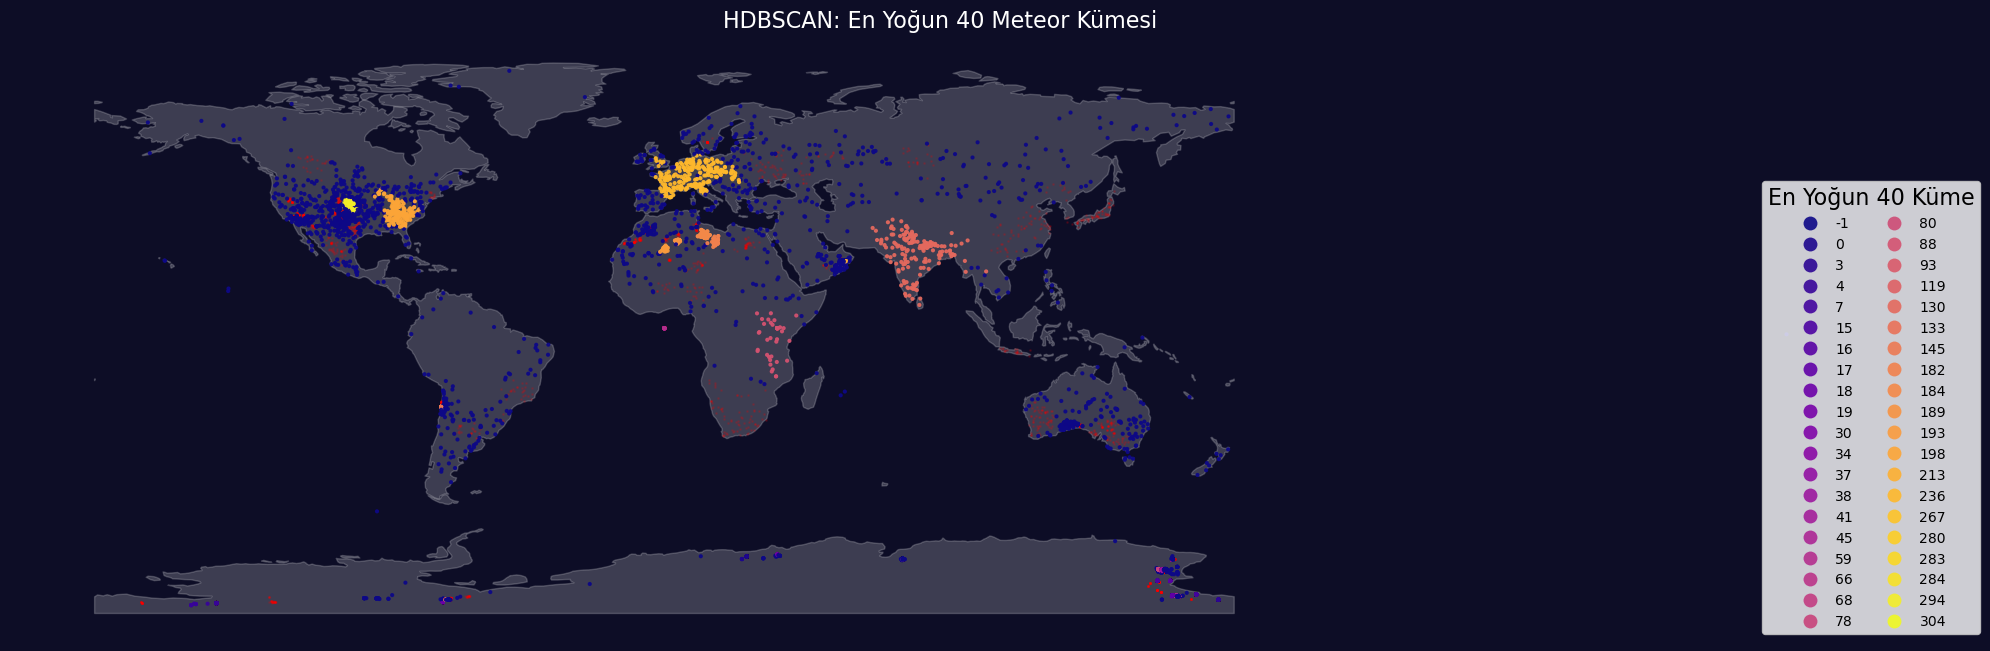

In [19]:
import matplotlib.pyplot as plt
import geopandas as gpd
from geodatasets import get_path

# Dünya haritası
world = gpd.read_file(get_path("naturalearth.land"))

# 🔢 En yoğun 40 kümeyi seç
top_40_clusters = meteor_gdf['hdbscan_cluster'].value_counts().head(40).index
meteor_top40 = meteor_gdf[meteor_gdf['hdbscan_cluster'].isin(top_40_clusters)]
meteor_other = meteor_gdf[~meteor_gdf['hdbscan_cluster'].isin(top_40_clusters)]

# 🔍 Harita çizimi
fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_facecolor('#0d0d26')

# Dünya katmanı
world.plot(ax=ax, color='white', edgecolor='white', alpha=0.2)

# Diğer tüm meteor noktalarını gri göster
meteor_other.plot(ax=ax, markersize=1, color='red', alpha=0.15)

# En yoğun 40 kümeyi renkli göster (legend daha büyük ve 2 sütun)
meteor_top40.plot(
    ax=ax,
    column='hdbscan_cluster',
    categorical=True,
    cmap='plasma',
    markersize=4,
    alpha=0.9,
    legend=True,
    legend_kwds={
        'loc': 'lower center',              # Alt merkeze konumlandır
        'bbox_to_anchor': (1, 0),      # Haritanın dışına taşır (yukarıdan aşağı)
        'title': 'En Yoğun 40 Küme',
        'ncol': 2,                          # 2 sütunlu görünüm
        'frameon': True,
        'fontsize': 10,                    # Yazı boyutu büyütülebilir
        'title_fontsize': 16
    }
)


plt.title("HDBSCAN: En Yoğun 40 Meteor Kümesi", fontsize=16, color='white')
ax.set_facecolor('#0d0d26')
ax.tick_params(colors='white')
plt.axis('off')
plt.tight_layout()
plt.show()


2️⃣ Geographically Weighted Regression (GWR)
Bu modelle:

Meteor mesafesi ve kıta etkisinin, şehir konumuna göre nasıl değiştiğini inceleyeceğiz

Yani "Asya’daki şehirlerde mesafe etkisi farklı mı? Avrupa’da farklı mı?" gibi mekânsal farkları modelleyeceğiz

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Modelleri tanımla
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": BernoulliNB()
}

# Sonuçları buraya toplayacağız
results = []

# Modelleri sırayla eğit ve değerlendir
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 3),
        'Precision': round(prec, 3),
        'Recall': round(rec, 3),
        'F1 Score': round(f1, 3)
    })

# Sonuçları DataFrame olarak göster
results_df = pd.DataFrame(results)
display(results_df)


C:\Users\yalaz\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.863,0.863,1.000,0.927
1,Decision Tree,0.863,0.863,1.000,0.927
2,Random Forest,0.863,0.863,1.000,0.927
3,XGBoost,0.863,0.863,1.000,0.927
4,KNN,0.856,0.891,0.949,0.919
5,Naive Bayes,0.856,0.891,0.949,0.919


C:\Users\yalaz\AppData\Local\Temp\ipykernel_9148\67385392.py:18: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\yalaz\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


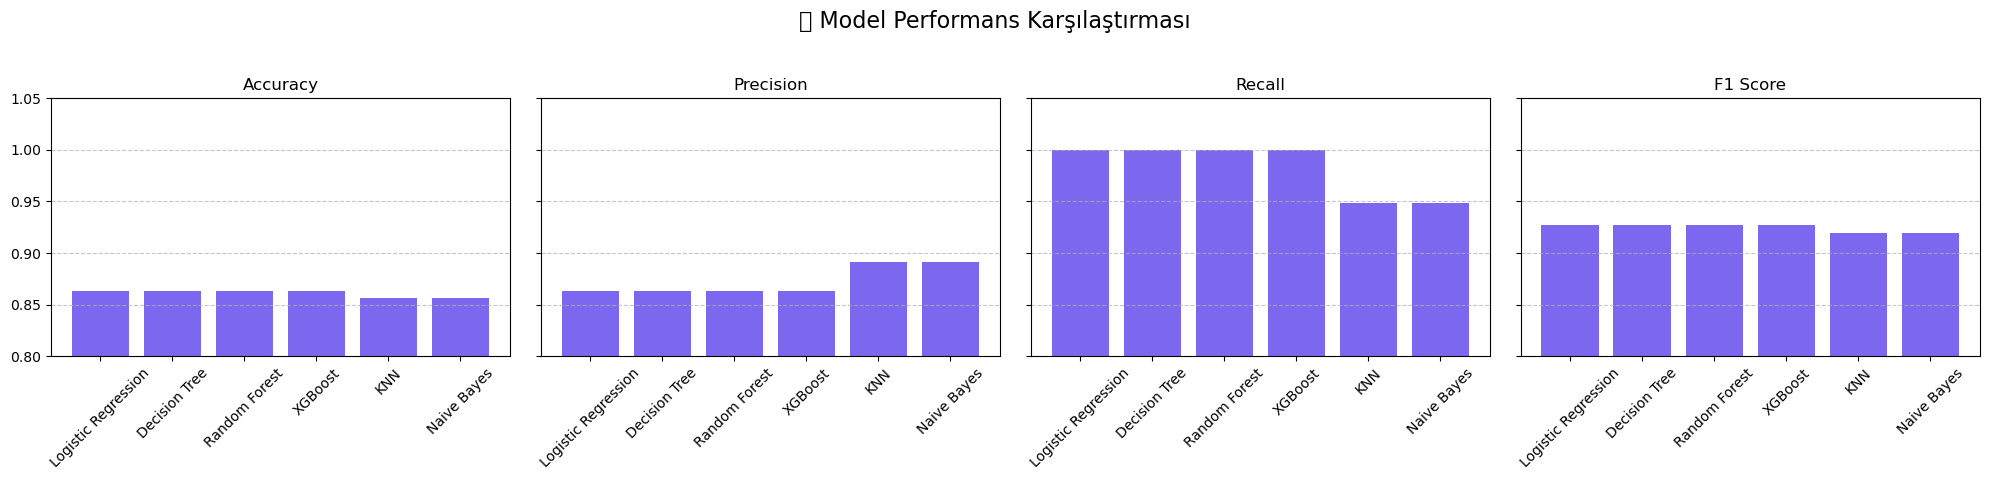

In [21]:
import matplotlib.pyplot as plt

# 📊 Verileri ayıkla
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = results_df['Model'].tolist()

# Her bir metrik için çizim yap
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.suptitle("🔍 Model Performans Karşılaştırması", fontsize=16)

for i, metric in enumerate(metrics):
    axes[i].bar(model_names, results_df[metric], color='mediumslateblue')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0.8, 1.05)  # daha net kıyaslama için ölçek sabit
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [22]:
from scipy.stats import ttest_ind

near = clean_data[clean_data['near_meteor'] == 1]['min_meteor_distance_m']
far = clean_data[clean_data['near_meteor'] == 0]['min_meteor_distance_m']

t_stat, p_val = ttest_ind(near, far, equal_var=False)


In [23]:
from scipy.stats import ttest_ind
import numpy as np

# Veri kontrolü: near ve far grupları var mı?
if 'min_meteor_distance_m' not in clean_data.columns or 'near_meteor' not in clean_data.columns:
    print("❌ Hata: 'clean_data' içinde gerekli sütunlar yok.")
else:
    near = clean_data[clean_data['near_meteor'] == 1]['min_meteor_distance_m']
    far = clean_data[clean_data['near_meteor'] == 0]['min_meteor_distance_m']

    # Boş grup kontrolü
    if len(near) == 0 or len(far) == 0:
        print("❌ Hata: 'near' veya 'far' grubu boş. Yeterli veri yok.")
    else:
        # T-Testi uygula
        t_stat, p_val = ttest_ind(near, far, equal_var=False)

        # Sonucu yazdır
        print("🔍 T-Test Sonucu (Meteora yakın vs uzak şehirler):")
        print(f"→ T-istatistiği: {t_stat:.3f}")
        print(f"→ P-değeri    : {p_val:.5f}")
        if p_val < 0.05:
            print("✅ Sonuç: İki grup arasında istatistiksel olarak anlamlı fark var (p < 0.05).")
        else:
            print("❌ Sonuç: Anlamlı fark bulunamadı (p ≥ 0.05).")


🔍 T-Test Sonucu (Meteora yakın vs uzak şehirler):
→ T-istatistiği: -9.805
→ P-değeri    : 0.00000
✅ Sonuç: İki grup arasında istatistiksel olarak anlamlı fark var (p < 0.05).
